C:\Users\cheth\AppData\Local\Temp\ipykernel_2660\830090112.py:64: RuntimeWarning: divide by zero encountered in divide
  evi = 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))


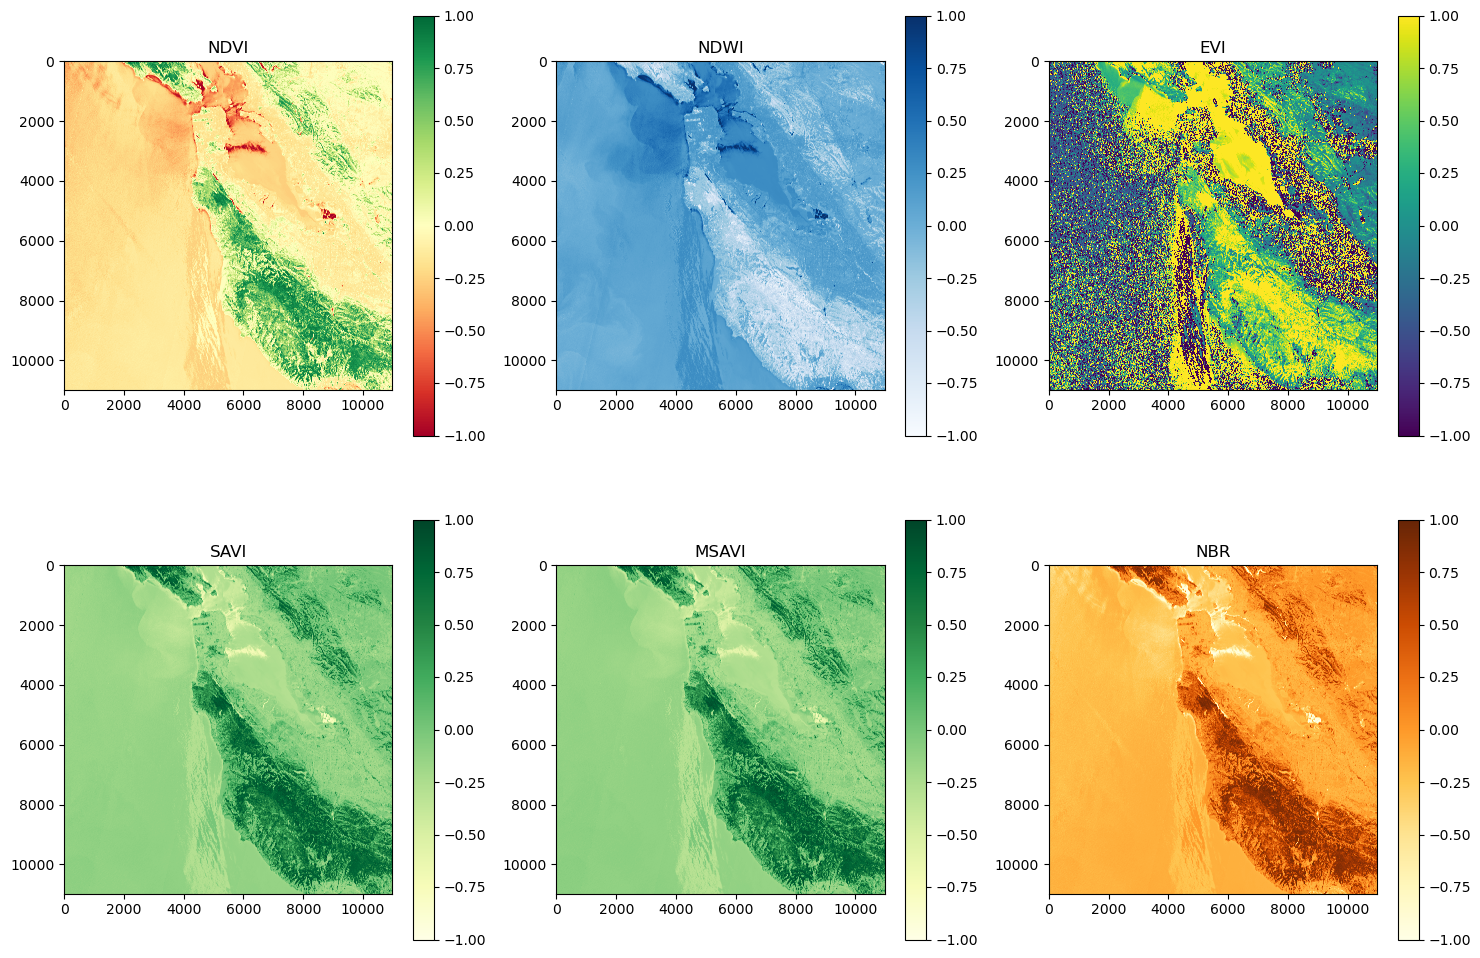

In [1]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from skimage import exposure, img_as_float
from scipy.ndimage import gaussian_filter

# Define file paths for the satellite images
image_files = {
    'B02': './T10SEG_20240627T184919_B02_10m.jp2',
    'B03': './T10SEG_20240627T184919_B03_10m.jp2',
    'B04': './T10SEG_20240627T184919_B04_10m.jp2',
    'B08': './T10SEG_20240627T184919_B08_10m.jp2',
}

# Load the bands
bands = {}
for band, path in image_files.items():
    with rasterio.open(path) as src:
        bands[band] = src.read(1).astype('float32')  # Ensure the data type is float32 for calculation

# Normalization function
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

# Apply normalization to all bands
for band in bands:
    bands[band] = normalize_band(bands[band])

# Noise reduction using Gaussian filter
def reduce_noise(band, sigma=1):
    return gaussian_filter(band, sigma=sigma)

# Apply noise reduction to all bands
for band in bands:
    bands[band] = reduce_noise(bands[band])

# Image enhancement using histogram equalization
def enhance_contrast(band):
    band = img_as_float(band)
    return exposure.equalize_hist(band)

# Apply contrast enhancement to all bands
for band in bands:
    bands[band] = enhance_contrast(bands[band])

# Calculate NDVI
def calculate_ndvi(b4, b8):
    ndvi = (b8 - b4) / (b8 + b4)
    ndvi[np.isnan(ndvi)] = 0  # Handle division by zero
    return ndvi

ndvi = calculate_ndvi(bands['B04'], bands['B08'])

# Calculate NDWI
def calculate_ndwi(b3, b8):
    ndwi = (b3 - b8) / (b3 + b8)
    ndwi[np.isnan(ndwi)] = 0  # Handle division by zero
    return ndwi

ndwi = calculate_ndwi(bands['B03'], bands['B08'])

# Calculate EVI (Enhanced Vegetation Index)
def calculate_evi(b2, b4, b8):
    evi = 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))
    evi[np.isnan(evi)] = 0  # Handle division by zero
    return evi

evi = calculate_evi(bands['B02'], bands['B04'], bands['B08'])

# Calculate SAVI (Soil Adjusted Vegetation Index)
def calculate_savi(b4, b8, L=0.5):
    savi = ((b8 - b4) / (b8 + b4 + L)) * (1 + L)
    savi[np.isnan(savi)] = 0  # Handle division by zero
    return savi

savi = calculate_savi(bands['B04'], bands['B08'])

# Calculate MSAVI (Modified Soil Adjusted Vegetation Index)
def calculate_msavi(b4, b8):
    msavi = (2 * b8 + 1 - np.sqrt((2 * b8 + 1) ** 2 - 8 * (b8 - b4))) / 2
    msavi[np.isnan(msavi)] = 0  # Handle division by zero
    return msavi

msavi = calculate_msavi(bands['B04'], bands['B08'])

# Calculate NBR (Normalized Burn Ratio)
def calculate_nbr(b4, b8):
    nbr = (b8 - b4) / (b8 + b4)
    nbr[np.isnan(nbr)] = 0  # Handle division by zero
    return nbr

nbr = calculate_nbr(bands['B04'], bands['B08'])

# Display all calculated features
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDVI')

plt.subplot(2, 3, 2)
plt.imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NDWI')

plt.subplot(2, 3, 3)
plt.imshow(evi, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar()
plt.title('EVI')

plt.subplot(2, 3, 4)
plt.imshow(savi, cmap='YlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('SAVI')

plt.subplot(2, 3, 5)
plt.imshow(msavi, cmap='YlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title('MSAVI')

plt.subplot(2, 3, 6)
plt.imshow(nbr, cmap='YlOrBr', vmin=-1, vmax=1)
plt.colorbar()
plt.title('NBR')

plt.show()


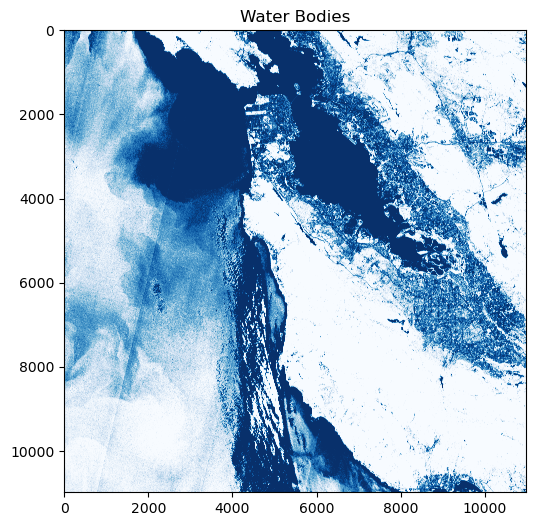

In [2]:
# Threshold NDWI to identify water bodies
water_bodies = ndwi > 0.1

plt.figure(figsize=(6, 6))
plt.imshow(water_bodies, cmap='Blues')
plt.title('Water Bodies')
plt.show()


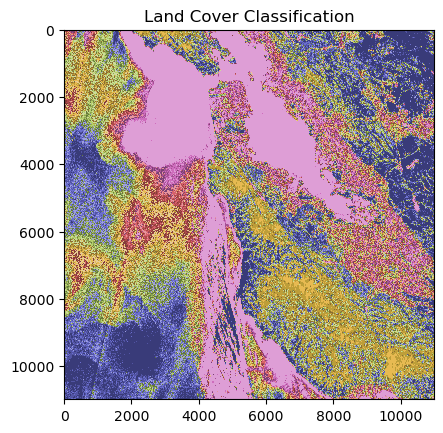

In [3]:
def classify_land_cover(ndvi, ndwi):
    land_cover = np.zeros_like(ndvi)
    land_cover[ndvi > 0.3] = 1  # Vegetation
    land_cover[(ndwi > 0.1) & (ndvi <= 0.3)] = 2  # Water
    return land_cover

land_cover = classify_land_cover(ndvi, ndwi)

plt.imshow(land_cover, cmap='tab20b')
plt.title('Land Cover Classification')
plt.show()


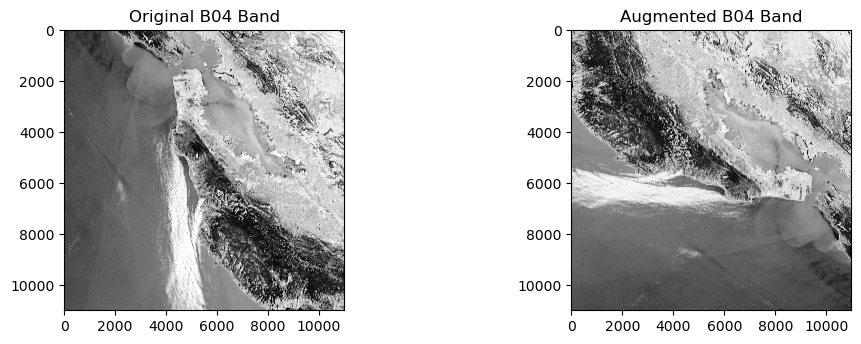

In [4]:
import random
from PIL import Image, ImageOps, ImageEnhance

# Data Augmentation
def augment_image(image_array):
    image = Image.fromarray((image_array * 255).astype('uint8'))  # Convert to uint8 for PIL processing
    
    # Random Rotation
    angle = random.choice([0, 90, 180, 270])
    image = image.rotate(angle)
    
    # Random Flipping
    if random.choice([True, False]):
        image = ImageOps.flip(image)
    if random.choice([True, False]):
        image = ImageOps.mirror(image)
    
    # Random Scaling
    scale_factor = random.uniform(0.8, 1.2)
    new_size = tuple([int(dim * scale_factor) for dim in image.size])
    image = image.resize(new_size, Image.LANCZOS)
    
    # Center Crop to original size
    image = ImageOps.fit(image, (image_array.shape[1], image_array.shape[0]), method=Image.LANCZOS)
    
    # Add random noise
    noise = np.random.normal(0, 0.1, (image_array.shape[0], image_array.shape[1])).astype('float32')
    image_array_noisy = np.array(image).astype('float32') / 255 + noise
    image_array_noisy = np.clip(image_array_noisy, 0, 1)
    
    return image_array_noisy

# Apply augmentations to each band
augmented_images = {band: augment_image(image) for band, image in bands.items()}

# Display original and augmented images for comparison
plt.figure(figsize=(12, 8))

# Original image example (Band B04)
plt.subplot(2, 2, 1)
plt.imshow(bands['B04'], cmap='gray')
plt.title('Original B04 Band')

# Augmented image example (Band B04)
plt.subplot(2, 2, 2)
plt.imshow(augmented_images['B04'], cmap='gray')
plt.title('Augmented B04 Band')

plt.show()

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('./FLORIDA.csv')

# Convert the date column to datetime format with dayfirst=True to handle dates in "dd/mm/yyyy" format
data['DATE'] = pd.to_datetime(data['DATE'], dayfirst=True, errors='coerce')

# Filter the data from January 1, 2004 onwards
# data = data[data['DATE'] >= '2004-01-01']

# Handle missing values by filling them with the mean of each column (excluding the date column)
columns_to_keep = ['PRCP', 'TMAX', 'TMIN']
data[columns_to_keep] = data[columns_to_keep].fillna(data[columns_to_keep].mean())

# Calculate the average temperature
data['TAVG'] = (data['TMAX'] + data['TMIN']) / 2

# Normalize the data (excluding the date column)
scaler = StandardScaler()
data[['PRCP', 'TMAX', 'TMIN', 'TAVG']] = scaler.fit_transform(data[['PRCP', 'TMAX', 'TMIN', 'TAVG']])

# Keep only the specified columns
columns_to_keep = ['DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN']
data = data[columns_to_keep]

# Display the normalized DataFrame
data.head()


,DATE,PRCP,TAVG,TMAX,TMIN
0,2004-01-01,-0.348652,-0.692322,-0.564367,-0.725106
1,2004-01-02,-0.348652,-0.476084,-0.685401,-0.279916
2,2004-01-03,-0.348652,-0.530143,-0.564367,-0.457992
3,2004-01-04,-0.348652,-0.422024,-0.443333,-0.368954
4,2004-01-05,-0.348652,-0.908560,-0.443333,-1.170296


C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

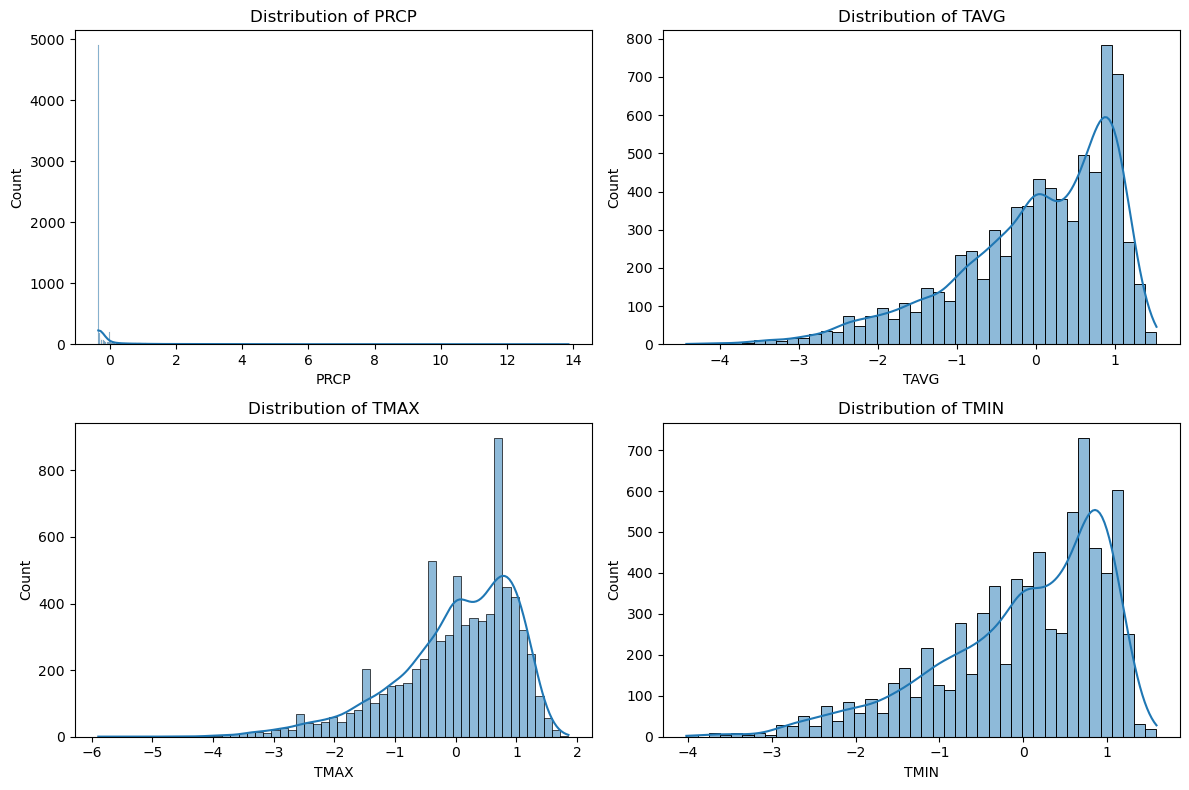

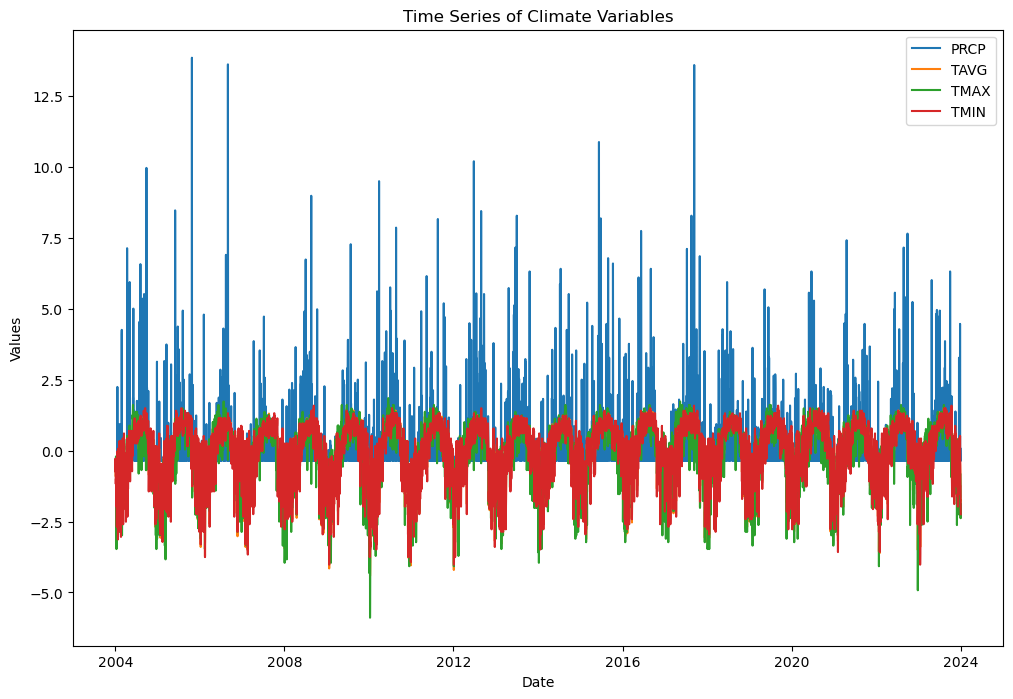

C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\cheth\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

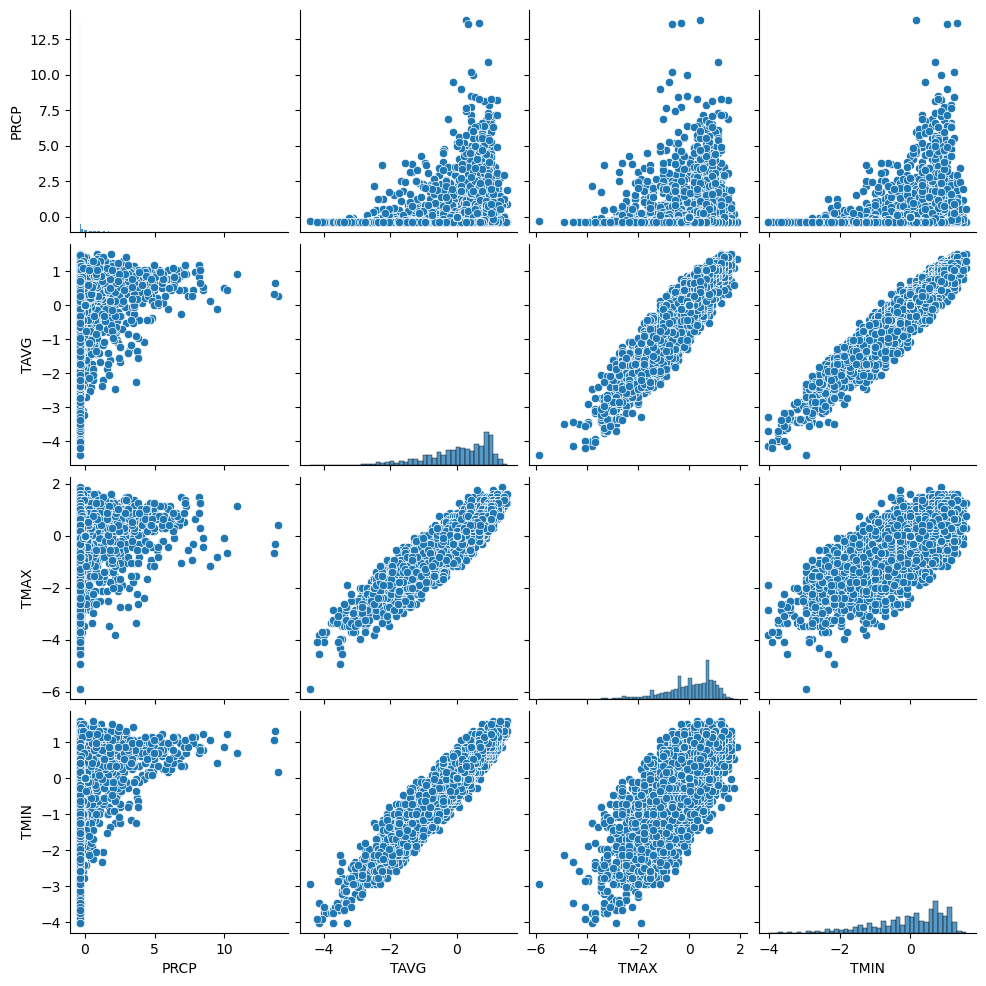

          PRCP      TAVG      TMAX      TMIN
PRCP  1.000000  0.177693  0.096305  0.221820
TAVG  0.177693  1.000000  0.930109  0.962807
TMAX  0.096305  0.930109  1.000000  0.796279
TMIN  0.221820  0.962807  0.796279  1.000000


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distributions of the variables
plt.figure(figsize=(12, 8))
for i, column in enumerate(columns_to_keep[1:], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

# Plot the time series of the variables
plt.figure(figsize=(12, 8))
for column in columns_to_keep[1:]:
    plt.plot(data['DATE'], data[column], label=column)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Time Series of Climate Variables')
plt.legend()
plt.show()

# Pairplot to visualize relationships
sns.pairplot(data[columns_to_keep[1:]])
plt.show()

# Correlation matrix
correlation_matrix = data[columns_to_keep[1:]].corr()

# Print the correlation matrix
print(correlation_matrix)


In [7]:
import numpy as np

# Create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Prepare the data for time series analysis
seq_length = 30  # Sequence length of 30 days
data_values = data[columns_to_keep[1:]].values
X, y = create_sequences(data_values, seq_length)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


Training data shape: (5952, 30, 4), Training labels shape: (5952, 4)
Testing data shape: (1488, 30, 4), Testing labels shape: (1488, 4)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Dense(4)  # Output layer with 4 neurons for PRCP, TAVG, TMAX, TMIN
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display the model architecture
model.summary()


C:\Users\cheth\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,204 (43.77 KB)

 Trainable params: 11,204 (43.77 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7203 - val_loss: 0.4191
Epoch 2/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4635 - val_loss: 0.3949
Epoch 3/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4042 - val_loss: 0.4005
Epoch 4/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4255 - val_loss: 0.3823
Epoch 5/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.4022 - val_loss: 0.3895
Epoch 6/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3985 - val_loss: 0.3806
Epoch 7/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3842 - val_loss: 0.3797
Epoch 8/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3963 - val_loss: 0.3784
Epoch 9/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.4167 - val_loss: 0.3766
Epoch 10/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4263 - val_loss: 0.3781
Epoch 11/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.4237 - val_loss: 0.3740
Epoch 12/50
149/149 ━━━━━━━━━━━━━━━━━━━━ 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3774
Test Loss: 0.3388530910015106


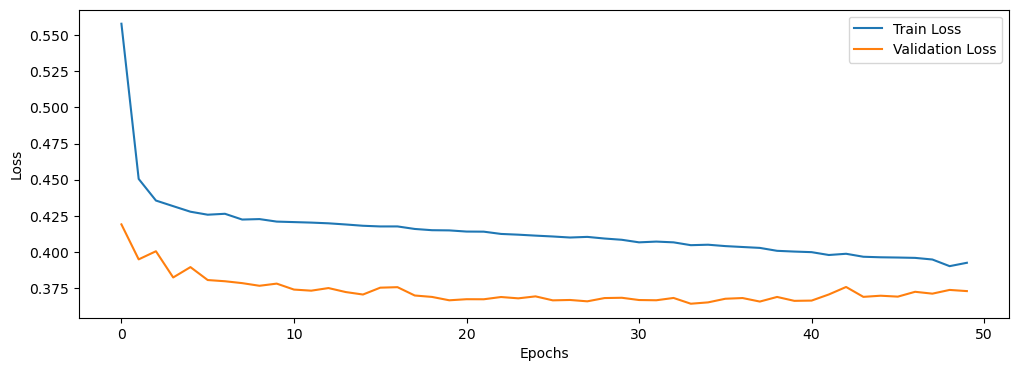

In [10]:
import matplotlib.pyplot as plt

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


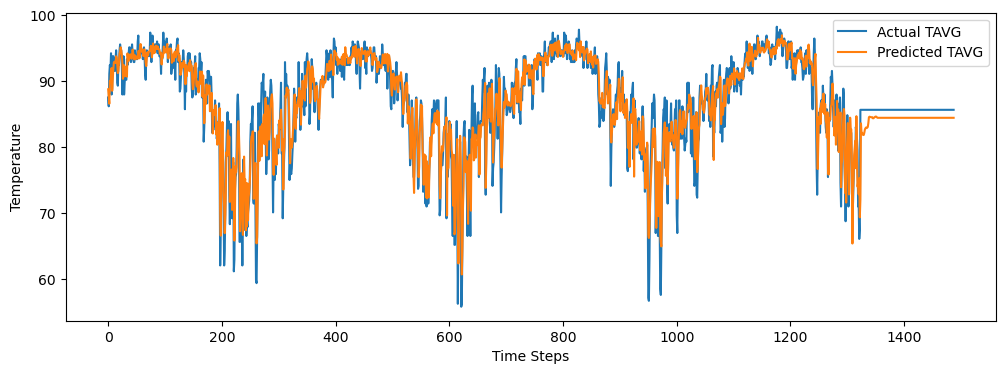

In [11]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to get the original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot the actual vs predicted values for TAVG (example)
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:, 1], label='Actual TAVG')
plt.plot(y_pred_inv[:, 1], label='Predicted TAVG')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()


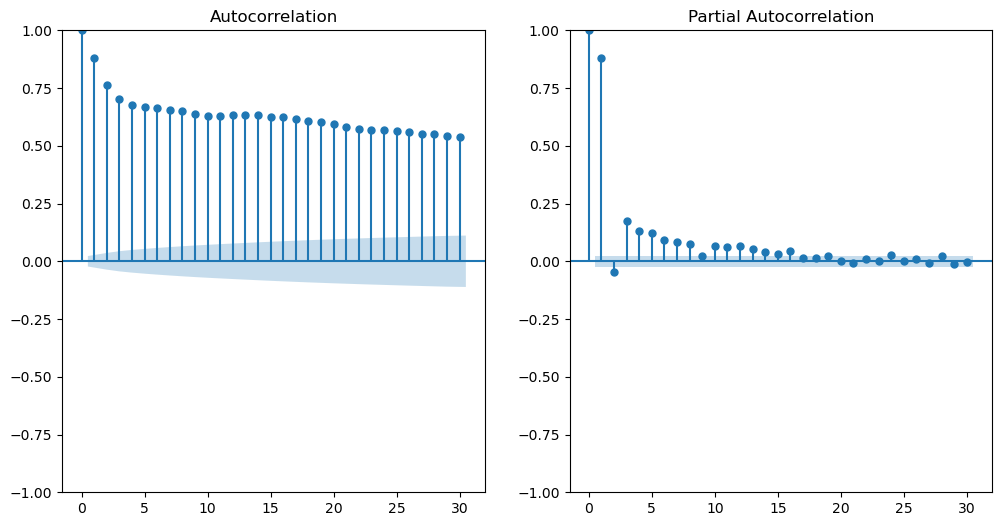

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the TAVG series
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data['TAVG'], ax=plt.gca(), lags=30)
plt.subplot(122)
plot_pacf(data['TAVG'], ax=plt.gca(), lags=30)
plt.show()


In [13]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model = ARIMA(data['TAVG'], order=(1, 0, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   TAVG   No. Observations:                 7470
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5052.372
Date:                Mon, 15 Jul 2024   AIC                          10112.744
Time:                        16:49:35   BIC                          10140.418
Sample:                             0   HQIC                         10122.249
                               - 7470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.062     -0.008      0.994      -0.122       0.121
ar.L1          0.8606      0.007    124.283      0.000       0.847       0.874
ma.L1          0.0806      0.010      7.977      0.0

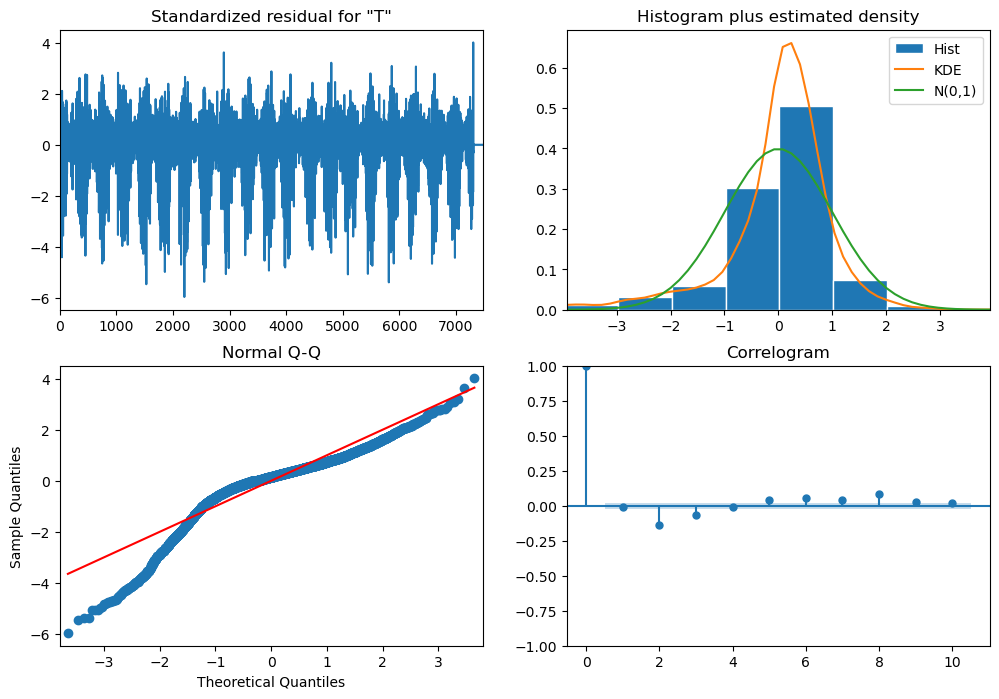

In [14]:
# Plot diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()


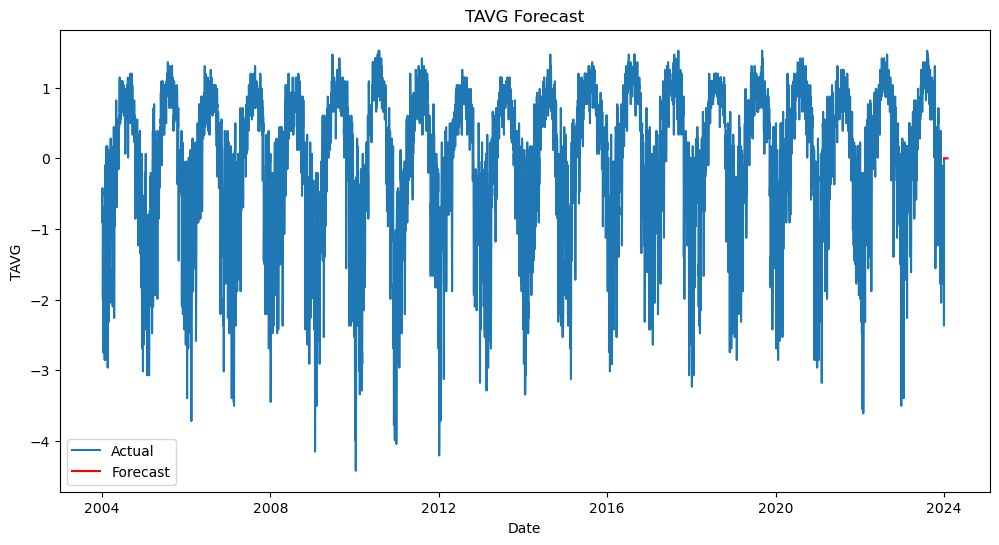

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure DATE column is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Handle missing values in the DATE column
data['DATE'] = data['DATE'].interpolate(method='linear', limit_direction='both')  # Linear interpolation

# Check if there are still any missing values
if data['DATE'].isna().any():
    print("There are still missing values in the DATE column. Please inspect the data.")
else:
    # Proceed with forecasting
    forecast_steps = 30  # Number of days to forecast
    forecast = model_fit.forecast(steps=forecast_steps)

    # Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(data['DATE'], data['TAVG'], label='Actual')
    forecast_dates = pd.date_range(start=data['DATE'].iloc[-1], periods=forecast_steps + 1, freq='D')[1:]  # Exclude the start date
    plt.plot(forecast_dates, forecast, label='Forecast', color='red')
    plt.xlabel('Date')
    plt.ylabel('TAVG')
    plt.title('TAVG Forecast')
    plt.legend()
    plt.show()


In [27]:
from sklearn.model_selection import train_test_split

# Split data into features and target
X = data[['PRCP', 'TMAX', 'TMIN']]
y = data['TAVG']  # Example target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)

# Evaluate the models
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)

print(f'Random Forest - MSE: {rf_mse}, MAE: {rf_mae}')
print(f'Gradient Boosting - MSE: {gb_mse}, MAE: {gb_mae}')


Random Forest - MSE: 0.0002955937766689238, MAE: 0.003399165215656675
Gradient Boosting - MSE: 0.0010432344307021739, MAE: 0.021163191363384883


In [31]:
from sklearn.svm import SVR

# Support Vector Regressor
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Evaluate the model
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_mae = mean_absolute_error(y_test, svm_predictions)

print(f'SVM - MSE: {svm_mse}, MAE: {svm_mae}')


SVM - MSE: 0.003004264228806106, MAE: 0.039890704349292844


In [33]:
from sklearn.model_selection import GridSearchCV

# Example for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
best_rf_predictions = best_rf_model.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_predictions)
best_rf_mae = mean_absolute_error(y_test, best_rf_predictions)

print(f'Best Random Forest - MSE: {best_rf_mse}, MAE: {best_rf_mae}')


C:\Users\cheth\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\cheth\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\cheth\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestR

Best Random Forest - MSE: 0.0002955937766689238, MAE: 0.003399165215656675


In [37]:
import numpy as np
import os
import rasterio
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Function to create image patches
def create_image_patches(stacked_images, patch_size=128):
    patches = []
    for i in range(0, stacked_images.shape[0] - patch_size + 1, patch_size):
        for j in range(0, stacked_images.shape[1] - patch_size + 1, patch_size):
            patch = stacked_images[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return np.array(patches)

# Load the bands and stack them to create multi-band images
def load_and_stack_bands(image_files):
    bands = []
    for key in image_files:
        with rasterio.open(image_files[key]) as src:
            band = src.read(1).astype('float32')
            bands.append(band)
    return np.stack(bands, axis=-1)

# Define the file paths for the satellite images
image_files = {
    'B02': './T10SEG_20240627T184919_B02_10m.jp2',
    'B03': './T10SEG_20240627T184919_B03_10m.jp2',
    'B04': './T10SEG_20240627T184919_B04_10m.jp2',
    'B08': './T10SEG_20240627T184919_B08_10m.jp2',
}

# Load and preprocess the satellite images
stacked_images = load_and_stack_bands(image_files)

# Create patches from the stacked images
image_patches = create_image_patches(stacked_images, patch_size=64)
print(f'Total patches created: {image_patches.shape[0]}')

# Create dummy labels for the patches (e.g., 0: forest, 1: water, 2: urban)
num_classes = 3
labels = np.random.randint(0, num_classes, image_patches.shape[0])

# One-hot encode the labels
labels = to_categorical(labels, num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_patches, labels, test_size=0.2, random_state=42)

# Data generators
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255  # Normalize images
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)


Total patches created: 29241


In [39]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 4)),  # 4 bands as input
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


C:\Users\cheth\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,939 (2.64 MB)

 Trainable params: 691,939 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)


Epoch 1/20


C:\Users\cheth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


731/731 ━━━━━━━━━━━━━━━━━━━━ 132s 172ms/step - accuracy: 0.3312 - loss: 1.1590 - val_accuracy: 0.3525 - val_loss: 1.0989
Epoch 2/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3600 - val_loss: 1.0983
Epoch 3/20


C:\Users\cheth\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


731/731 ━━━━━━━━━━━━━━━━━━━━ 110s 149ms/step - accuracy: 0.3322 - loss: 1.0998 - val_accuracy: 0.3319 - val_loss: 1.0987
Epoch 4/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3200 - val_loss: 1.0988
Epoch 5/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 323s 441ms/step - accuracy: 0.3336 - loss: 1.0989 - val_accuracy: 0.3322 - val_loss: 1.0983
Epoch 6/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3200 - val_loss: 1.1002
Epoch 7/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 110s 150ms/step - accuracy: 0.3339 - loss: 1.0988 - val_accuracy: 0.3314 - val_loss: 1.0984
Epoch 8/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 104us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4800 - val_loss: 1.0953
Epoch 9/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 109s 148ms/step - accuracy: 0.3314 - loss: 1.0988 - val_accuracy: 0.3511 - val_loss: 1.0978
Epoch 10/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 125us/step - accuracy: 0.0

182/182 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.3255 - loss: 1.0987
Validation Loss: 1.0985640287399292
Validation Accuracy: 0.33190247416496277


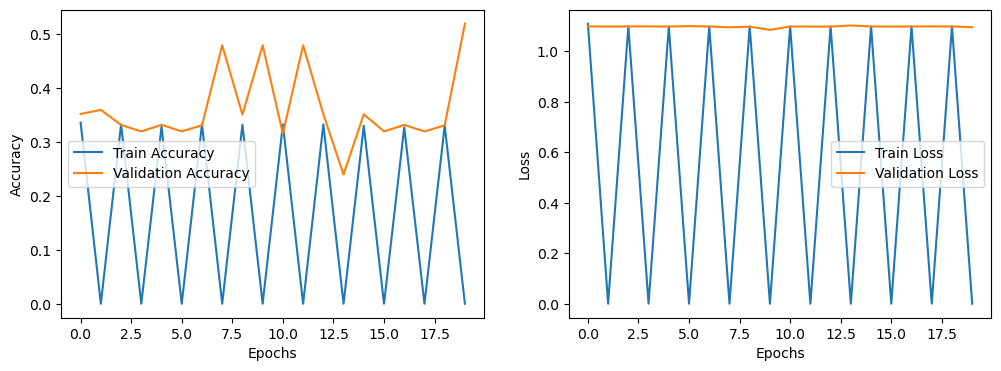

In [43]:
# Evaluate the model
val_loss, val_acc = model.evaluate(val_generator, steps=len(X_val) // 32)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [45]:
# Function to predict land cover class for a given image patch
def predict_land_cover(model, image_patch):
    image_patch = np.expand_dims(image_patch, axis=0)  # Add batch dimension
    prediction = model.predict(image_patch)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Example prediction
example_patch = image_patches[3]
predicted_class = predict_land_cover(model, example_patch)
print(f'Predicted Land Cover Class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Predicted Land Cover Class: 2
